# Importing Libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load the dataset from the provided path
metadata_path = r"/Users/apple/Documents/PROJECT RESEARCH/Dataset/HAMM 2/HAM10000_metadata.csv"
df = pd.read_csv(metadata_path)


2024-12-12 01:04:26.593269: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Loading - Meta file

In [3]:
# Load the dataset from the provided path
metadata_path = r"/Users/apple/Documents/PROJECT RESEARCH/Dataset/HAMM 2/HAM10000_metadata.csv"
df = pd.read_csv(metadata_path)

# Data Cleaning

In [7]:
df.head

<bound method NDFrame.head of            image_id     dx   age sex localization  is_malignant  \
0      ISIC_0027419    bkl  80.0   m        scalp             0   
1      ISIC_0025030    bkl  80.0   m        scalp             0   
2      ISIC_0026769    bkl  80.0   m        scalp             0   
3      ISIC_0025661    bkl  80.0   m        scalp             0   
4      ISIC_0031633    bkl  75.0   m          ear             0   
...             ...    ...   ...  ..          ...           ...   
10010  ISIC_0033084  akiec  40.0   m      abdomen             1   
10011  ISIC_0033550  akiec  40.0   m      abdomen             1   
10012  ISIC_0033536  akiec  40.0   m      abdomen             1   
10013  ISIC_0032854  akiec  80.0   m         face             1   
10014  ISIC_0032258    mel  70.0   f         back             0   

                                              image_path  
0      /Users/apple/Documents/PROJECT RESEARCH/Datase...  
1      /Users/apple/Documents/PROJECT RESEARCH/

In [3]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Remove duplicates if any
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")
df = df.drop_duplicates()

# Ensure there are no invalid ages (negative or zero values)
df = df[df['age'] > 0]

# Check for missing values again after cleaning
print("\nMissing Values After Cleaning:")
print(df.isnull().sum())


Missing Values:
lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

Number of duplicate rows: 0

Missing Values After Cleaning:
lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64


In [4]:
# Drop rows with missing critical information
critical_columns = ['image_id', 'dx', 'age', 'sex', 'localization']
initial_rows = len(df)
df = df.dropna(subset=critical_columns)
dropped_rows = initial_rows - len(df)
print(f"Dropped {dropped_rows} rows with missing critical values.")

# Fill missing non-critical values
df['age'] = df['age'].fillna(df['age'].median()) 
df['sex'] = df['sex'].fillna('unknown') 

# Standardize categorical columns
df['sex'] = df['sex'].str.lower().replace({'male': 'm', 'female': 'f', 'unknown': 'u'})
print("\nStandardized 'sex' column values.")

# Filter out invalid age values
df = df[df['age'] > 0]
print("Removed rows with invalid age values (<= 0).")

# Add a binary classification column for malignant/benign
malignant_classes = ['melanoma', 'bcc', 'akiec']
df['is_malignant'] = df['dx'].apply(lambda x: 1 if x in malignant_classes else 0)
print("Added 'is_malignant' column.")


Dropped 57 rows with missing critical values.

Standardized 'sex' column values.
Removed rows with invalid age values (<= 0).
Added 'is_malignant' column.


In [5]:

# Validate and map image paths
img_dir_part1 = r"/Users/apple/Documents/PROJECT RESEARCH/Dataset/HAMM 2/HAM10000_images_part_1"
img_dir_part2 = r"/Users/apple/Documents/PROJECT RESEARCH/Dataset/HAMM 2/HAM10000_images_part_2"
df['image_path'] = df['image_id'].apply(
    lambda x: os.path.join(img_dir_part1, f"{x}.jpg") 
    if os.path.exists(os.path.join(img_dir_part1, f"{x}.jpg")) 
    else os.path.join(img_dir_part2, f"{x}.jpg")
)
missing_images = df['image_path'].apply(lambda x: not os.path.exists(x)).sum()
df = df[df['image_path'].apply(os.path.exists)]
print(f"Removed {missing_images} rows with missing or invalid image paths.")

# Normalize column names for consistency
df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_')
print("Normalized column names.")

# Drop irrelevant columns
irrelevant_columns = ['lesion_id', 'dx_type']  # Adjust as needed
df = df.drop(columns=irrelevant_columns, errors='ignore')
print("Dropped irrelevant columns.")

# Check final dataset state
print("\nFinal Dataset Overview:")
print(df.info())
print(df.head())

# Save cleaned metadata for future use
cleaned_metadata_path = r"/Users/apple/Documents/PROJECT RESEARCH/Dataset/HAMM 2/HAM10000_metadata_cleaned.csv"
df.to_csv(cleaned_metadata_path, index=False)
print(f"Cleaned metadata saved to: {cleaned_metadata_path}")


Removed 0 rows with missing or invalid image paths.
Normalized column names.
Dropped irrelevant columns.

Final Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9919 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image_id      9919 non-null   object 
 1   dx            9919 non-null   object 
 2   age           9919 non-null   float64
 3   sex           9919 non-null   object 
 4   localization  9919 non-null   object 
 5   is_malignant  9919 non-null   int64  
 6   image_path    9919 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 619.9+ KB
None
       image_id   dx   age sex localization  is_malignant  \
0  ISIC_0027419  bkl  80.0   m        scalp             0   
1  ISIC_0025030  bkl  80.0   m        scalp             0   
2  ISIC_0026769  bkl  80.0   m        scalp             0   
3  ISIC_0025661  bkl  80.0   m        scalp             0   
4 

# Exporatory Data Analysis

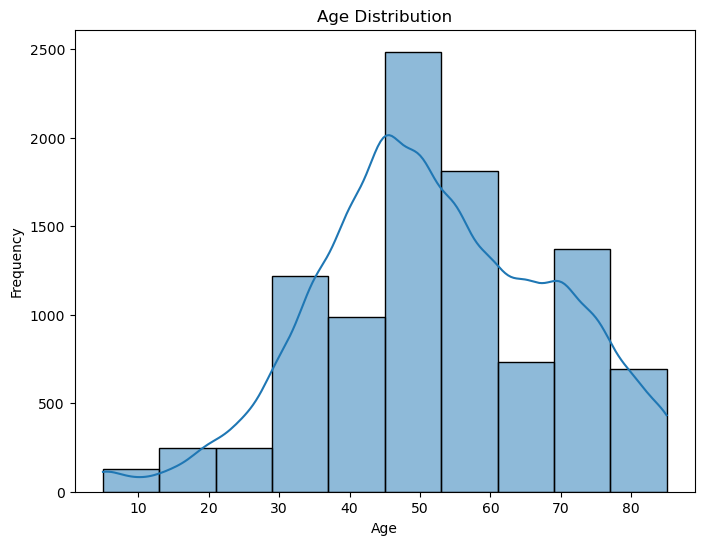

In [16]:
# Age Distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['age'], bins=10, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

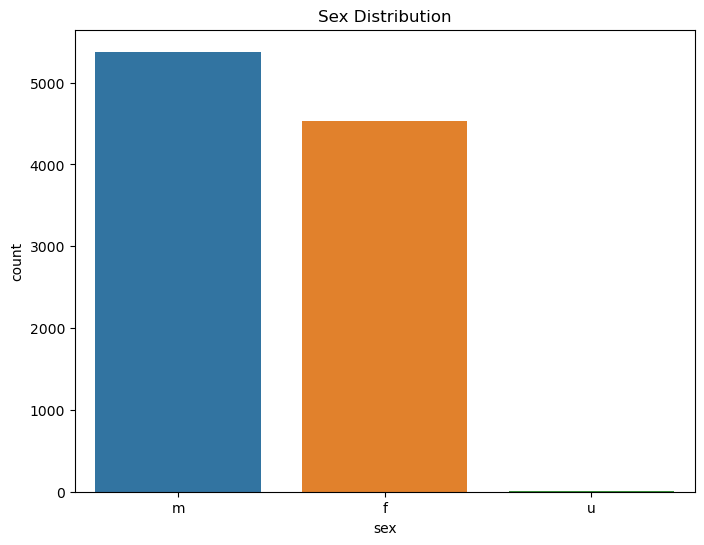

In [17]:
# Sex Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sex', data=df)
plt.title('Sex Distribution')
plt.show()

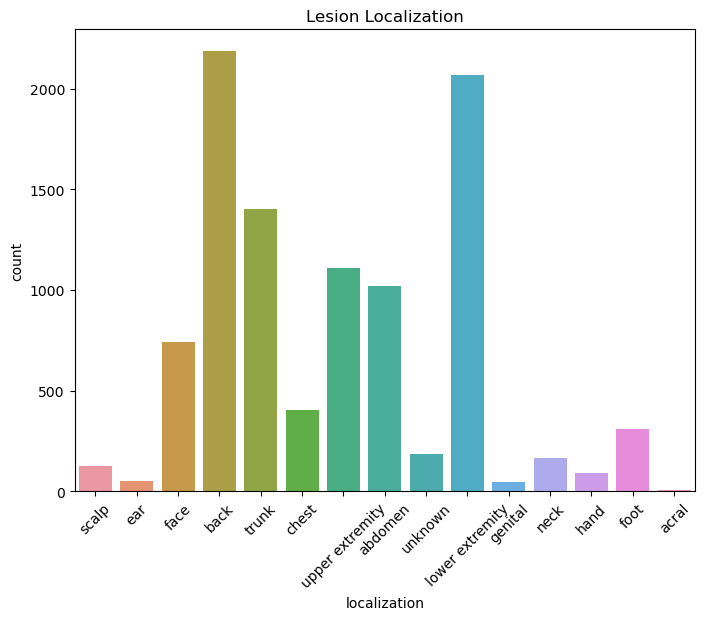

In [18]:
# Lesion Localization Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='localization', data=df)
plt.title('Lesion Localization')
plt.xticks(rotation=45)
plt.show()

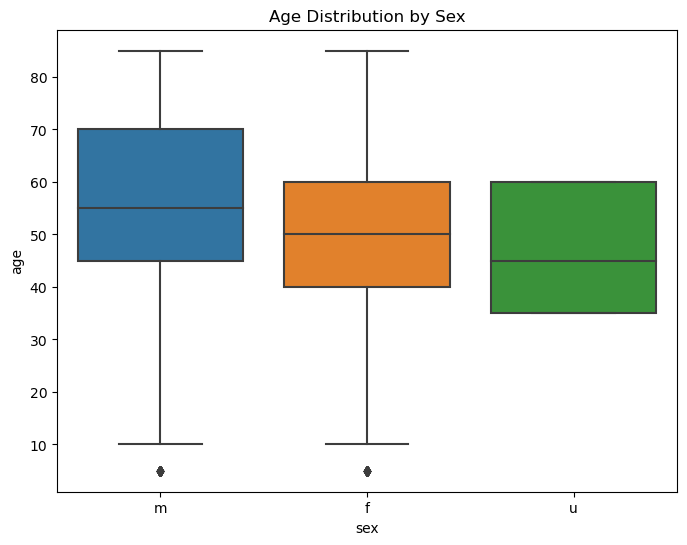

In [19]:
# Age vs Sex Distribution 
plt.figure(figsize=(8, 6))
sns.boxplot(x='sex', y='age', data=df)
plt.title('Age Distribution by Sex')
plt.show()

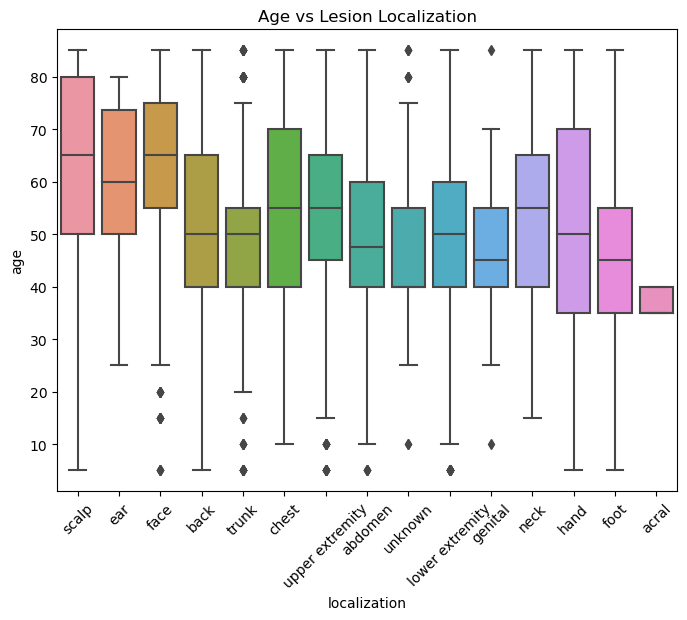

In [20]:
# Age vs Localization 
plt.figure(figsize=(8, 6))
sns.boxplot(x='localization', y='age', data=df)
plt.title('Age vs Lesion Localization')
plt.xticks(rotation=45)
plt.show()

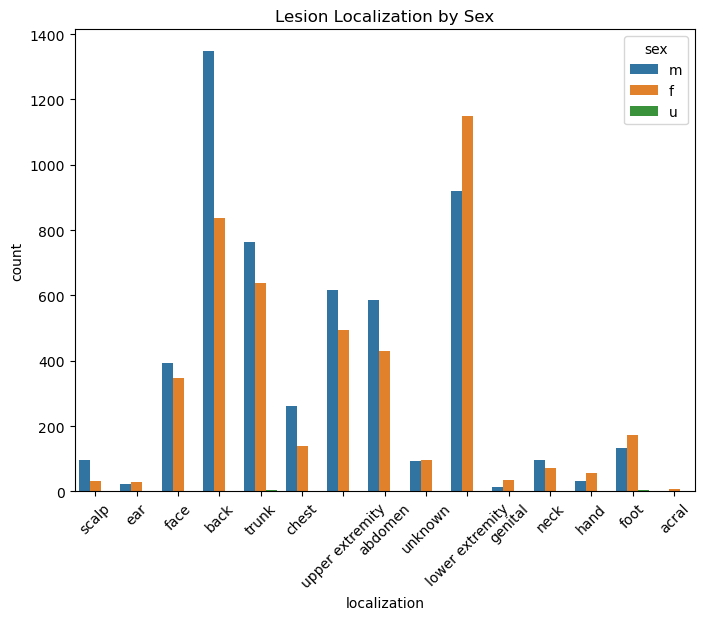

In [21]:
# Sex vs Localization Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='localization', hue='sex', data=df)
plt.title('Lesion Localization by Sex')
plt.xticks(rotation=45)
plt.show()

# Image Directory Loading

In [22]:
# Paths
metadata_path = r"/Users/apple/Documents/PROJECT RESEARCH/Dataset/HAMM 2/HAM10000_metadata.csv"
img_dir_part1 = r"/Users/apple/Documents/PROJECT RESEARCH/Dataset/HAMM 2/HAM10000_images_part_1"
img_dir_part2 = r"/Users/apple/Documents/PROJECT RESEARCH/Dataset/HAMM 2/HAM10000_images_part_2"

# Target size for images
target_size = (224, 224)
batch_size = 32
metadata = pd.read_csv(metadata_path)

# Add image paths
metadata['image_path'] = metadata['image_id'].apply(
    lambda x: os.path.join(img_dir_part1, f"{x}.jpg") 
    if os.path.exists(os.path.join(img_dir_part1, f"{x}.jpg")) 
    else os.path.join(img_dir_part2, f"{x}.jpg")
)

# Map diagnosis to numeric labels
label_mapping = {label: idx for idx, label in enumerate(metadata['dx'].unique())}
metadata['class'] = metadata['dx'].map(label_mapping)

# Data Spliting

In [11]:
# Train-Test Split
train_df, test_df = train_test_split(metadata, test_size=0.2, stratify=metadata['class'], random_state=42)

# Convert class column to strings for ImageDataGenerator
train_df['class'] = train_df['class'].astype(str)
test_df['class'] = test_df['class'].astype(str)

# Intialising Data Generator

In [12]:
# ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    x_col='image_path', 
    y_col='class', 
    target_size=target_size, 
    batch_size=batch_size, 
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    x_col='image_path', 
    y_col='class', 
    target_size=target_size, 
    batch_size=batch_size, 
    class_mode='categorical', 
    shuffle=False
)


Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


# CNN Models - Training, Building & Evaluating

Training ResNet50...
Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 486s 2s/step - accuracy: 0.6383 - loss: 1.2753 - val_accuracy: 0.6695 - val_loss: 1.1370
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 468s 2s/step - accuracy: 0.6741 - loss: 1.1547 - val_accuracy: 0.6695 - val_loss: 1.1225
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 456s 2s/step - accuracy: 0.6692 - loss: 1.1569 - val_accuracy: 0.6695 - val_loss: 1.1159
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 466s 2s/step - accuracy: 0.6705 - loss: 1.1379 - val_accuracy: 0.6695 - val_loss: 1.1250
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 486s 2s/step - accuracy: 0.6669 - loss: 1.1505 - val_accuracy: 0.6695 - val_loss: 1.1117
63/63 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step
ResNet50 Confusion Matrix Summary:
Correctly Classified Samples: 1341
Misclassified Samples: 662
ResNet50 Metrics:
Accuracy: 0.67
Precision: 0.67
Recall: 0.67
F1 Score: 0.67
Training DenseNet121...
Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 678s 3s/step - accuracy: 0.6492 - loss: 1.0879 - val_accuracy:

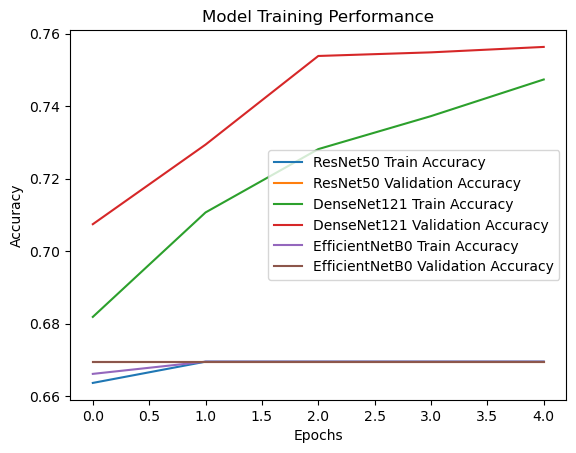

In [14]:
# Model Building
def build_model(base_model_class):
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(len(label_mapping), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train Models
models = {
    'ResNet50': ResNet50,
    'DenseNet121': DenseNet121,
    'EfficientNetB0': EfficientNetB0
}

results = {}

for model_name, base_model_class in models.items():
    print(f"Training {model_name}...")
    model = build_model(base_model_class)
    history = model.fit(train_generator, validation_data=test_generator, epochs=5)
    
    # Evaluate model
    y_true = test_generator.classes
    y_pred = np.argmax(model.predict(test_generator), axis=1)
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    correct = np.trace(cm)
    misclassified = np.sum(cm) - correct
    accuracy = correct / np.sum(cm)
    precision = np.sum(cm.diagonal()) / np.sum(cm)
    recall = correct / (correct + misclassified)
    f1 = 2 * (precision * recall) / (precision + recall)

    print(f"{model_name} Confusion Matrix Summary:")
    print(f"Correctly Classified Samples: {correct}")
    print(f"Misclassified Samples: {misclassified}")
    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    
    results[model_name] = history

# Ploting Training Results
for model_name, history in results.items():
    plt.plot(history.history['accuracy'], label=f'{model_name} Train Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'{model_name} Validation Accuracy')
plt.title('Model Training Performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
